In [1]:
import xarray as xr
from utils.data import load_atmospheric_predictor

# Define the variables and region
variables = ["msl", "msl_gradient"]
region = (150, -20, 250, 50)
estela = True


# Load the ERA5 dynamic predictors
# era5_dynamic = load_atmospheric_predictor(
#     variables=variables, region=region, estela=estela
# )
era5_dynamic = xr.open_dataset("data/era5_dynamic.nc")
era5_dynamic

<xarray.Dataset> Size: 16GB
Dimensions:       (time: 30642, latitude: 181, longitude: 360)
Coordinates:
  * latitude      (latitude) float32 724B 89.62 88.62 87.62 ... -89.38 -90.0
  * time          (time) datetime64[ns] 245kB 1940-01-01 ... 2023-11-22
  * longitude     (longitude) float32 1kB 0.375 1.375 2.375 ... 358.4 359.4
Data variables:
    msl           (time, latitude, longitude) float32 8GB ...
    msl_gradient  (time, latitude, longitude) float32 8GB ...

In [5]:
era5_dynamic.sel(time="2000").coarsen(longitude=4, latitude=4, boundary="pad").mean()

<xarray.Dataset> Size: 12MB
Dimensions:       (time: 366, latitude: 46, longitude: 90)
Coordinates:
  * latitude      (latitude) float32 184B 88.12 84.12 80.12 ... -87.88 -90.0
  * time          (time) datetime64[ns] 3kB 2000-01-01 2000-01-02 ... 2000-12-31
  * longitude     (longitude) float32 360B 1.875 5.875 9.875 ... 353.9 357.9
Data variables:
    msl           (time, latitude, longitude) float32 6MB nan nan ... nan nan
    msl_gradient  (time, latitude, longitude) float32 6MB nan nan ... nan nan

In [5]:
from bluemath_tk.datamining.pca import PCA
from bluemath_tk.datamining.kma import KMA
from bluemath_tk.predictor.xwt import XWT

pca = PCA(n_components=0.8)
kma = KMA(num_clusters=36, seed=42)

xwt = XWT(steps={"pca": pca, "kma": kma})
xwt.fit(
    data=era5_dynamic.isel(time=slice(50, None)),
    fit_params={
        "pca": {
            "vars_to_stack": variables,
            "coords_to_stack": ["latitude", "longitude"],
            "pca_dim_for_rows": "time",
        },
        "kma": {
            "normalize_data": False,
            # "min_number_of_points": 10,
        },
    },
    variable_to_sort_bmus="msl",
)
xwt.save_model("outputs/dwt_model_aveiro.pkl")

2025-03-26 17:45:53,653 - PCA - WARNING - Changing variable OMP_NUM_THREADS from 1 to 1. 
And setting self.num_workers to 1. 
To avoid conflicts with BlueMath parallel processing.
2025-03-26 17:45:53,657 - KMA - WARNING - Changing variable OMP_NUM_THREADS from 1 to 1. 
And setting self.num_workers to 1. 
To avoid conflicts with BlueMath parallel processing.
2025-03-26 17:45:53,660 - XWT - WARNING - Changing variable OMP_NUM_THREADS from 1 to 1. 
And setting self.num_workers to 1. 
To avoid conflicts with BlueMath parallel processing.



        -------------------------------------------------------------------
        | Initializing PCA reduction model with the following parameters:
        |    - n_components: 0.8
        |    - is_incremental: False
        | For more information, please refer to the documentation.
        -------------------------------------------------------------------
        


2025-03-26 17:48:48,047 - PCA - WARNING - Attribute pcs is an xarray Dataset / Dataarray and will be pickled!


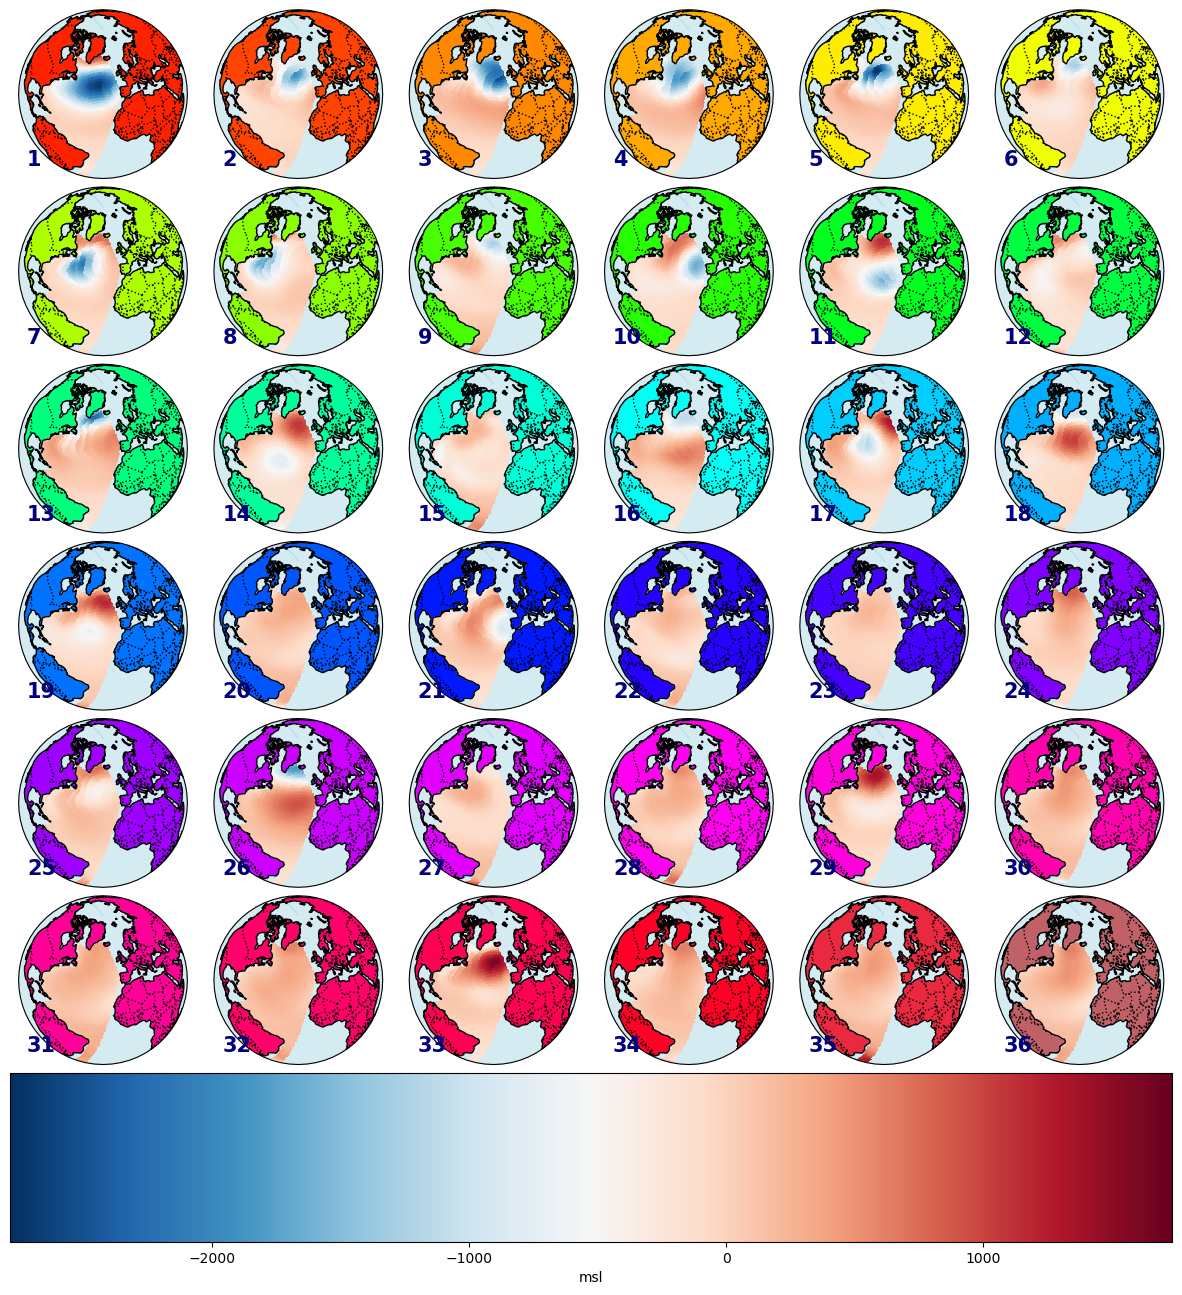

In [6]:
xwt.plot_xwts(var_to_plot="msl", anomaly=True, map_center=(-25, 40))

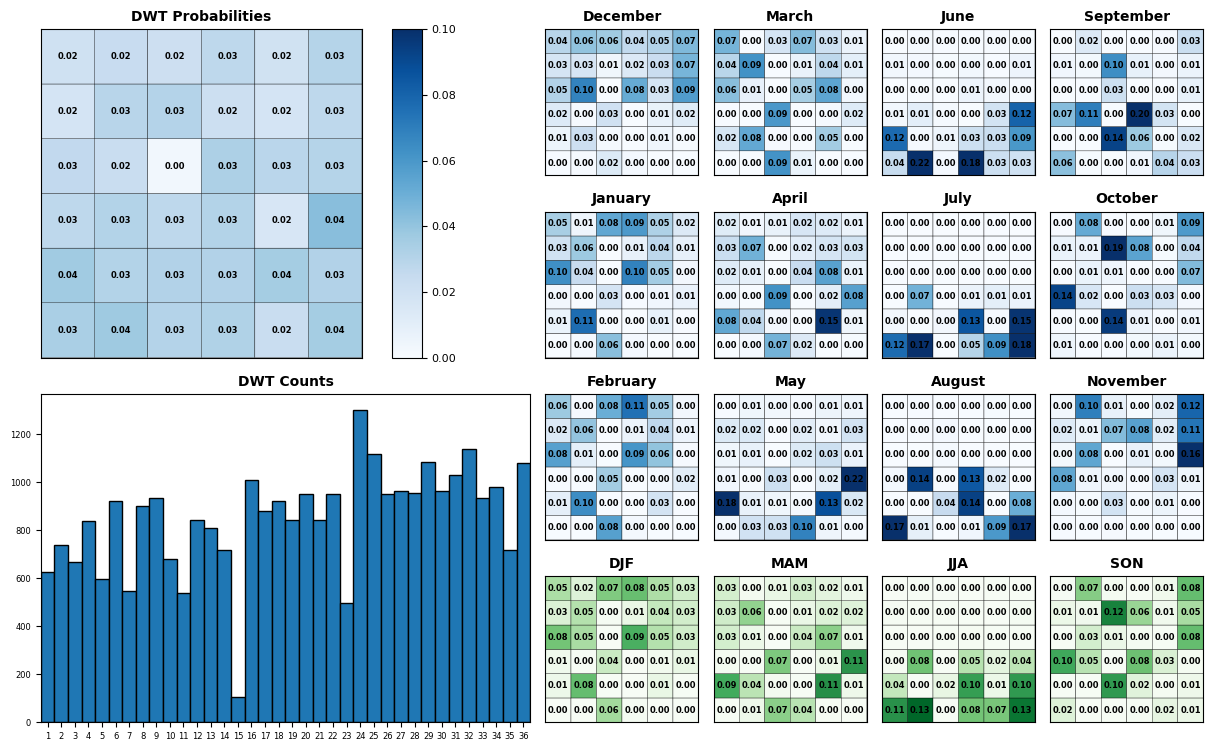

In [7]:
xwt.plot_dwts_probs(plot_text=True)

<Axes: >

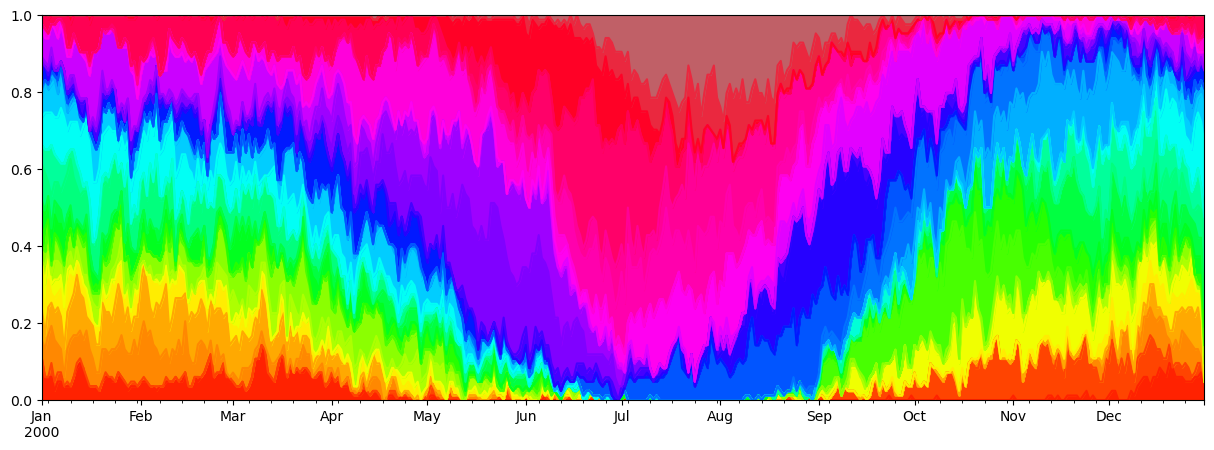

In [8]:
xwt.plot_perpetual_year()